# Data Merging and Cleaning

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

In [140]:
hh = pd.read_csv('data/hhpub.csv')
per = pd.read_csv('data/perpub.csv')
veh = pd.read_csv('data/vehpub.csv')
trip = pd.read_csv('data/trippub.csv')

The original NHTS data comprises four components: household, person, vehicle, and trip. Our research question, "how does retirement change elderly people's driving habits," leads us to focus on two specific household types: 1) households with two or more adults and no children (LC2), 2) households with two or more retired adults and no children (LC10).

In [141]:
# Take out all LC2 household ID
LC2_HOUSEID = hh[(hh['LIF_CYC'] == 2)].loc[:, "HOUSEID"]

# Take out all LC10 household ID
LC10_HOUSEID = hh[(hh['LIF_CYC'] == 10)].loc[:, "HOUSEID"]

# A Closer Inspect

Before proceeding with this comparison, I aim to assess whether we have an adequate number of participants in these two groups with similar ages. Specifically, I intend to examine the age distribution of households in the LC2 category to determine whether there are enough individuals approaching retirement age, making them comparable to those in the LC10 category.

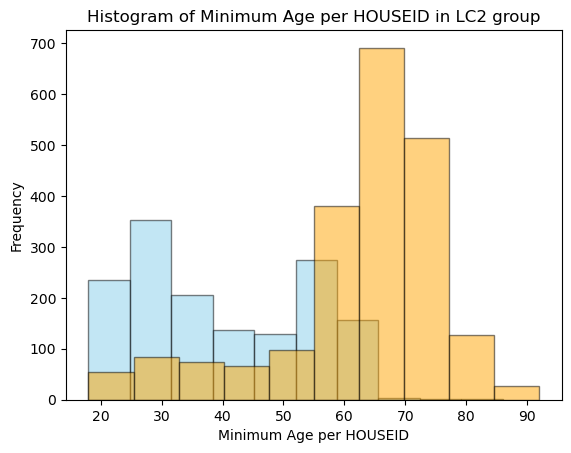

LC2 between 55 and 70 household#: 335
LC10 between 55 and 70 household#: 1159


In [142]:
LC2_PER = per[per['HOUSEID'].isin(LC2_HOUSEID)]
LC10_PER = per[per['HOUSEID'].isin(LC10_HOUSEID)]

# Group by 'HOUSEID' and obtain the minimum age for each 'HOUSEID'
LC2_minAGE = LC2_PER.groupby('HOUSEID')['R_AGE'].min()
LC10_minAGE = LC10_PER.groupby('HOUSEID')['R_AGE'].min()

# Plot a histogram
plt.hist(LC2_minAGE, bins=10, color='skyblue', edgecolor='black', alpha=0.5, label='LC2')
plt.hist(LC10_minAGE, bins=10, color='orange', edgecolor='black', alpha=0.5, label='LC10')
plt.xlabel('Minimum Age per HOUSEID')
plt.ylabel('Frequency')
plt.title('Histogram of Minimum Age per HOUSEID in LC2 group')
plt.show()

print('LC2 between 55 and 70 household#:', sum((55 <= LC2_minAGE) & (LC2_minAGE <= 70)))
print('LC10 between 55 and 70 household#:', sum((55 <= LC10_minAGE) & (LC10_minAGE <= 70)))

It appears that we have 335 households in the LC2 category with members aged between 55 and 70, whereas there are 1159 households in the LC10 category within the same age range. While this presents a discrepancy, it's not overly concerning at this stage.

I am now gonna take out all LC2 and LC10 as our main dataset.

In [143]:
# Filter out HOUSEIDs where the minimum age does not fall within the range of 55 and 70
LC2_target = LC2_minAGE[(55 <= LC2_minAGE) & (LC2_minAGE <= 70)]
LC10_target = LC10_minAGE[(55 <= LC10_minAGE) & (LC10_minAGE <= 70)]

# Filter main DataFrame to include only the target HOUSEIDs
target_HOUSEID = pd.concat([LC2_target, LC10_target]).index 
target = hh[hh['HOUSEID'].isin(target_HOUSEID)]

# Merging

Instead of doing all summarizing and merging by hand, I wrote a function. Once we determine the appropriate summarization methods for each variable, we can utilize this function to efficiently generate household-level variables. 

In [145]:
def summarize_pH(lower, target_var, agg_funcs=['mean'], group_var='HOUSEID'):
    """
    Summarizes lower-level data by household and returns aggregated features.

    Parameters:
        lower (DataFrame): Lower-level DataFrame.
        group_var (str): Name of the column containing household IDs.
        target_var (str): Name of the column containing the target variable to summarize.
        agg_funcs (list or str): List of aggregation functions to apply or a single aggregation function.
                                  Default is ['mean'].

    Returns:
        DataFrame: DataFrame containing aggregated features by household.
    """
    if isinstance(agg_funcs, str):
        agg_funcs = [agg_funcs]

    # Group by household ID and compute summary statistics for the target variable
    summary_df = lower.groupby(group_var)[target_var].agg(agg_funcs).reset_index()

    # Rename columns to include aggregation function suffix
    new_cols = [group_var] + [f"{target_var}_{agg}" for agg in agg_funcs]
    summary_df.columns = new_cols

    return summary_df

For instance, let's take out the total annual miles of each household.

In [146]:
MILES = summarize_pH(veh, 'ANNMILES', 'sum')

target = target.merge(MILES, 'left')

## Preliminary Analysis

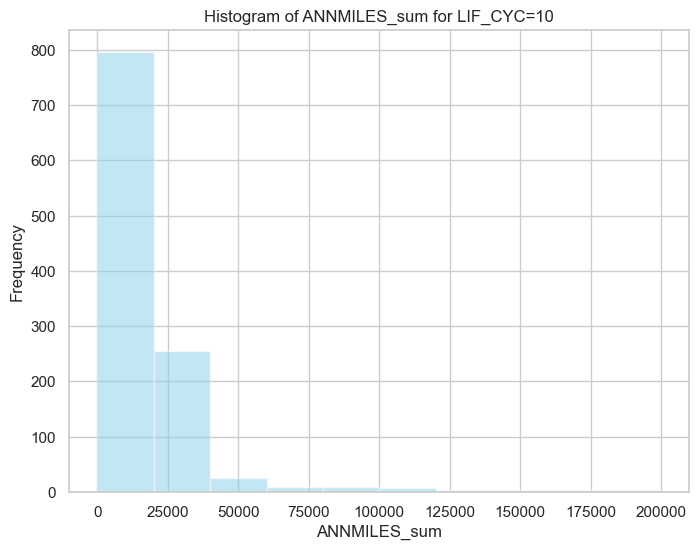

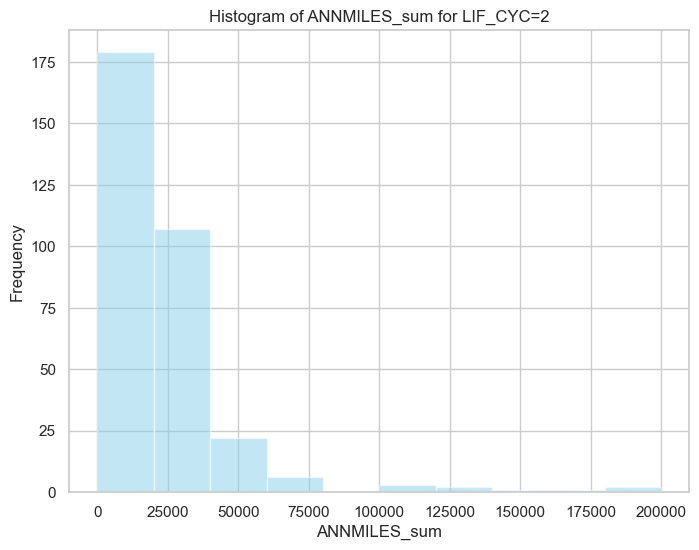

In [155]:
# Get unique 'LIF_CYC' values
lif_cyc_values = target['LIF_CYC'].unique()

# Create separate plots for each 'LIF_CYC' value
for lif_cyc_value in lif_cyc_values:
    subset = target[target['LIF_CYC'] == lif_cyc_value]
    plt.figure(figsize=(8, 6))
    plt.hist(subset['ANNMILES_sum'], alpha=0.5, color='skyblue', range=(0, 200000))
    plt.xlabel('ANNMILES_sum')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of ANNMILES_sum for LIF_CYC={lif_cyc_value}')
    plt.show()